# Install and Import Requirements

In [ ]:
! pip install pandas
! pip install transformers datasets evaluate rouge_score
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [24]:
import pandas as pd
import csv
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from IPython.display import HTML
import random
from matplotlib.image import imread
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Load dataset

In [3]:
df = pd.read_csv('booksummaries.csv', delimiter='\t' , names=["Path", "Title", "Author","Date", "Info", "Text"])

# Data Cleaning 

### Check missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16559 entries, 620 to 37159503
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  14177 non-null  object
 3   Date    10949 non-null  object
 4   Info    12841 non-null  object
 5   Text    16559 non-null  object
dtypes: object(6)
memory usage: 905.6+ KB


### Our project primarily relies on the 'Text' column, which is free from NaN values. To maintain data completeness, any missing values in other columns are replaced with designated values rather than being removed.

In [5]:
df['Author'] = df['Author'].fillna("unknown")
df['Date'] = df['Date'].apply(lambda x: int(x[:4]) if isinstance(x, str) and x[:4].isdigit() else -1) #Standardize data by ensuring all entries have a consistent year format. Missing years are represented as '-1'.
df['Info'] = df['Info'].fillna("{}")
df = df.reset_index(drop = True)



### checking the result

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  16559 non-null  object
 3   Date    16559 non-null  int64 
 4   Info    16559 non-null  object
 5   Text    16559 non-null  object
dtypes: int64(1), object(5)
memory usage: 776.3+ KB


# Exploratory Data Analysis

### 1- Explore the dataset's genre distribution. Show the top 10 most frequent genres visually.


In [121]:
genres = {}  
info = df.Info.to_list()
for i in range(len(info)):
    tmp = json.loads(info[i])
    for _, value in tmp.items():
        if value in genres:
            genres[value] += 1
        else:
            genres[value] = 1



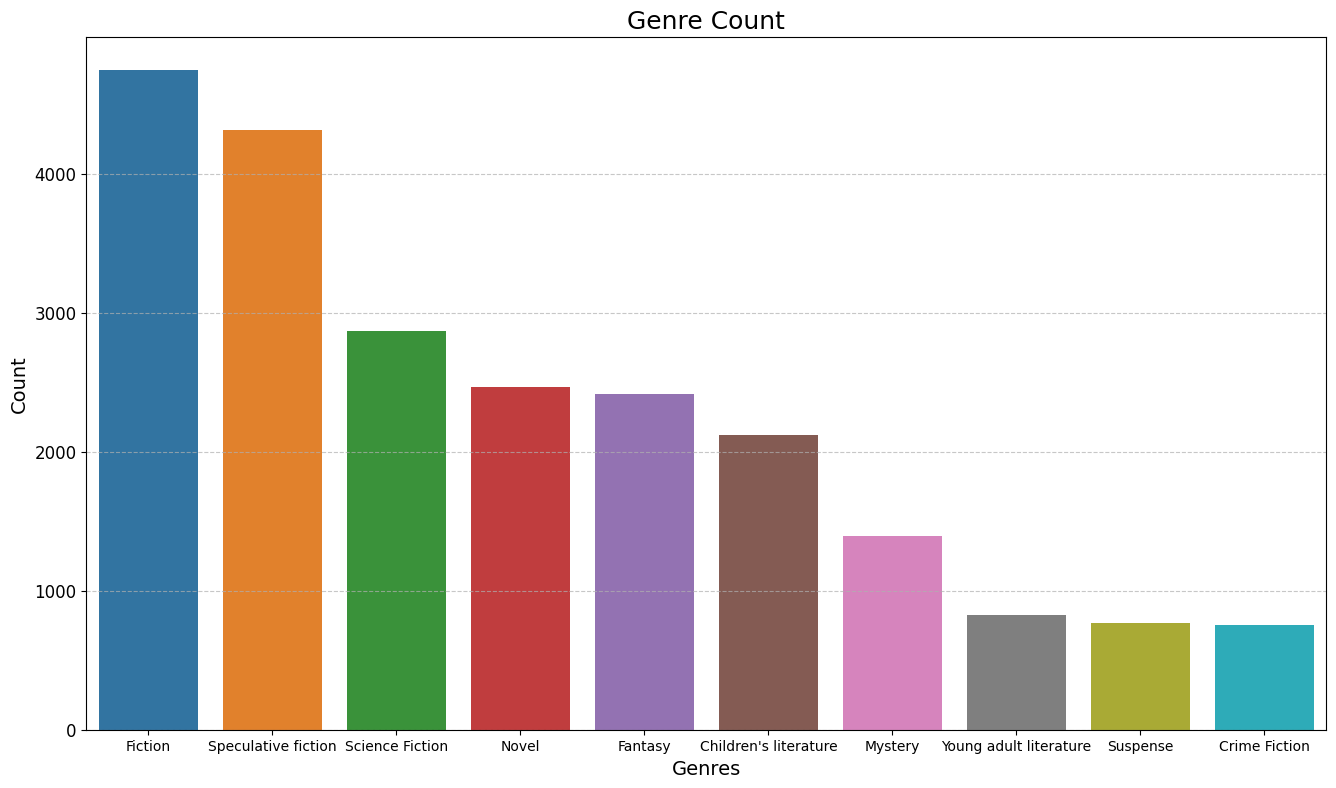

In [122]:
#picking the most frequent genras 
sorted_genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=True))  
top_10_genres = dict(list(sorted_genres.items())[:10])

plt.figure(figsize=(16, 9))

#choosing the color palette for the plot from seaborn
palette = sns.color_palette("tab10")

sns.barplot(x=list(top_10_genres.keys()), y=list(top_10_genres.values()), palette=palette)


plt.title('Genre Count', fontsize=18)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### what if we just consider the main genra of each book

In [184]:
genres = {}
info = df.Info.to_list()
for i in range(len(info)):
    tmp = json.loads(info[i])   
    if len(list(tmp.values())) > 0:
        value = list(tmp.values())[0]  #this time we only take the first parameter 
        if value in genres:
            genres[value] += 1
        else:
            genres[value] = 1

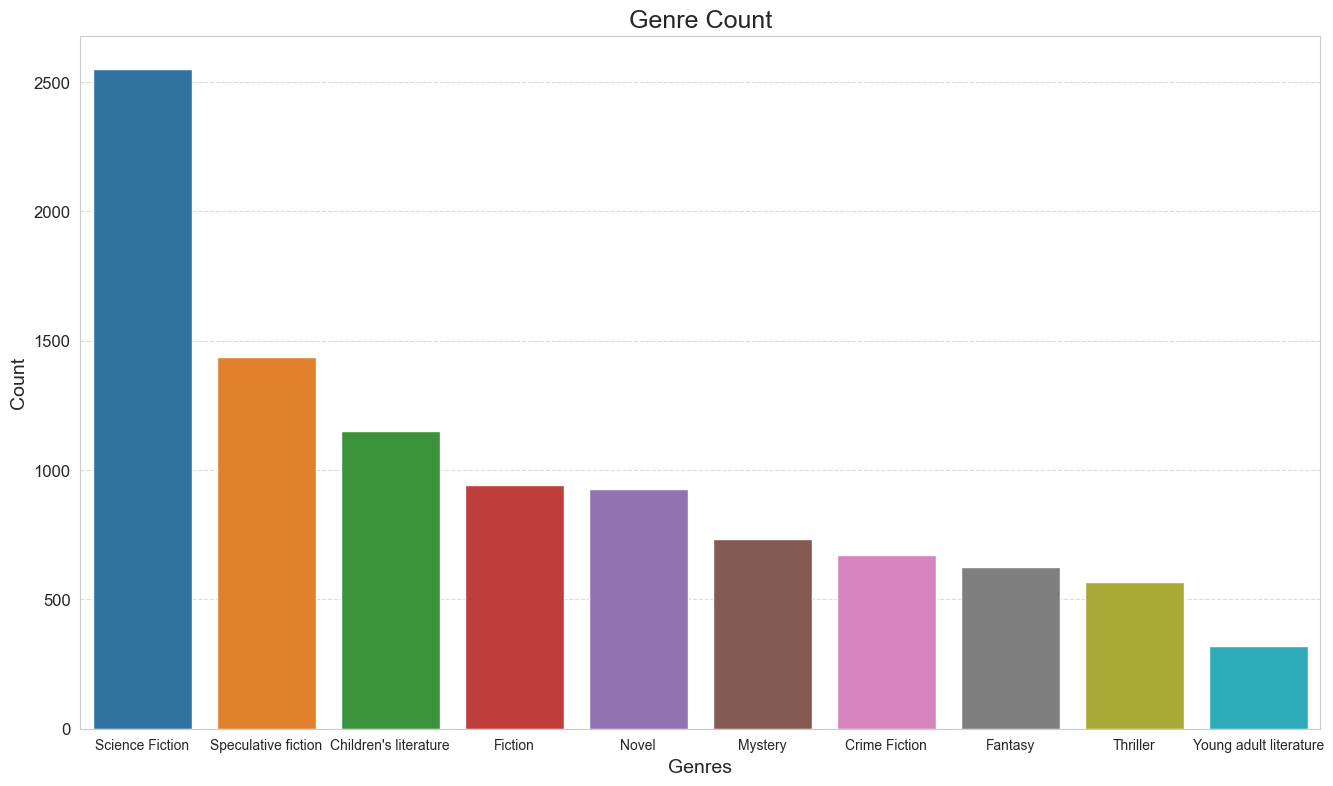

In [185]:
sorted_genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=True))
top_10_genres = dict(list(sorted_genres.items())[:10])

plt.figure(figsize=(16, 9))

palette = sns.color_palette("tab10")

sns.barplot(x=list(top_10_genres.keys()), y=list(top_10_genres.values()), palette=palette)


plt.title('Genre Count', fontsize=18)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### 2- Showing the distribution of different types of fiction books throughout the years


In [35]:
year = df[df['Date'] > 1800]['Date'].tolist()
genre = df[df['Date'] > 1800]['Info'].tolist()
years = []
genras = []
for i in range(len(genre)):
    tmp = json.loads(genre[i])
    for _, value in tmp.items():
        if value in ['Science Fiction', 'Crime Fiction', 'Speculative fiction', 'Horror']:  # The fiction types 
            years.append(year[i])
            genras.append(value)




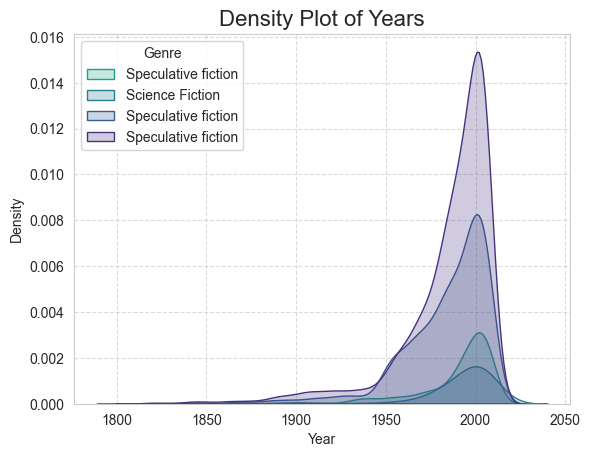

In [37]:
sns.set_style("whitegrid")
sns.set_palette("viridis")

sns.kdeplot(x=years , hue = genras, shade=True)



plt.xlabel('Year')
plt.ylabel('Density')
plt.title('Density Plot of Years')
plt.legend(genras, loc='upper left', title="Genre")
plt.title('Density Plot of Years', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


### 3- Which authors have published the most books?


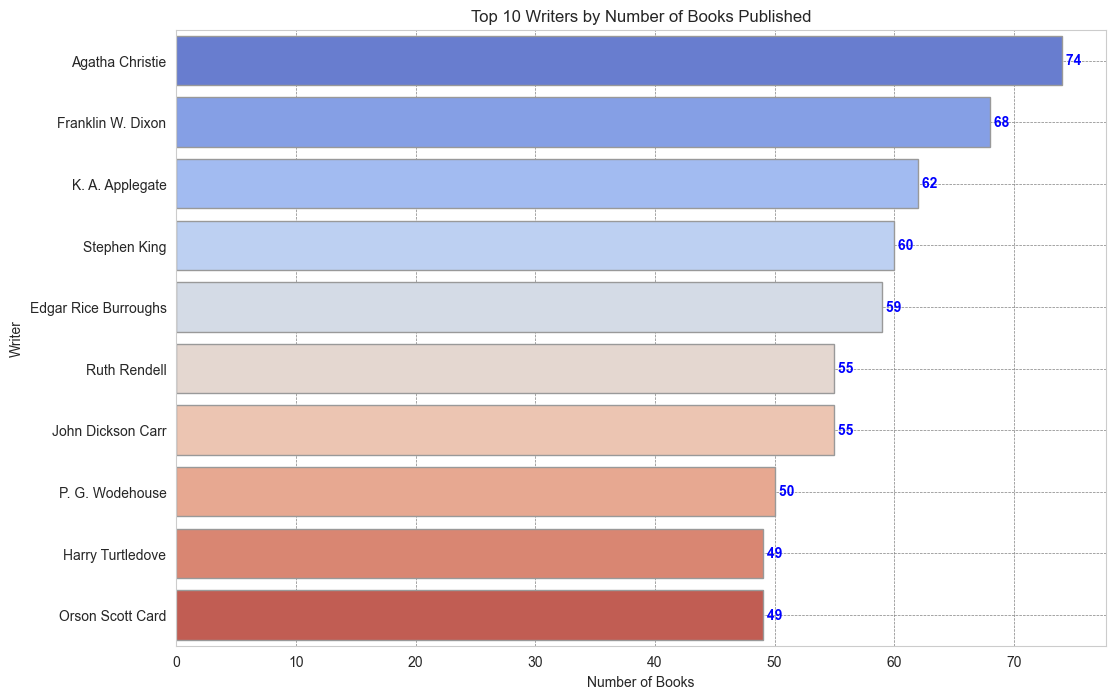

In [201]:
df_2 = df.copy()
df_2 = df_2[df_2['Author'] != 'unknown']


top_authors = df_2['Author'].value_counts().nlargest(10)

authors = top_authors.index
book_counts = top_authors.values

plt.figure(figsize=(12, 8))
sns.barplot(x=book_counts, y=authors, palette='coolwarm', edgecolor='.6')
plt.title('Top 10 Writers by Number of Books Published')
plt.xlabel('Number of Books')
plt.ylabel('Writer')

for index, value in enumerate(book_counts):
    plt.text(value, index, f' {value}', va='center', ha='left', fontweight='bold', color='blue')   # to add the numbers in front of bars 

plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
plt.show()

### 4- Are certain authors more inclined to write in specific genres?

In [8]:
df_3 = df[df['Author'] != 'unknown'].copy()

def extract_main_genre(genre_json):
    try:
        genre_data = json.loads(genre_json)
        return next(iter(genre_data.values())) if genre_data else None
    except json.JSONDecodeError:
        return None

df_3['Info'] = df_3['Info'].astype(str) #as type to str if it's not to make it faster to run

df_3['main_genre'] = df_3['Info'].apply(extract_main_genre)

df_3.dropna(subset=['main_genre'], inplace=True)

In [11]:
genre_author_matrix = df_3.groupby(['Author', 'main_genre']).size().unstack(fill_value=0)

top_genres = genre_author_matrix.sum().nlargest(10).index

genre_author_matrix = genre_author_matrix[top_genres]


In [16]:
df.columns

Index(['Path', 'Title', 'Author', 'Date', 'Info', 'Text'], dtype='object')

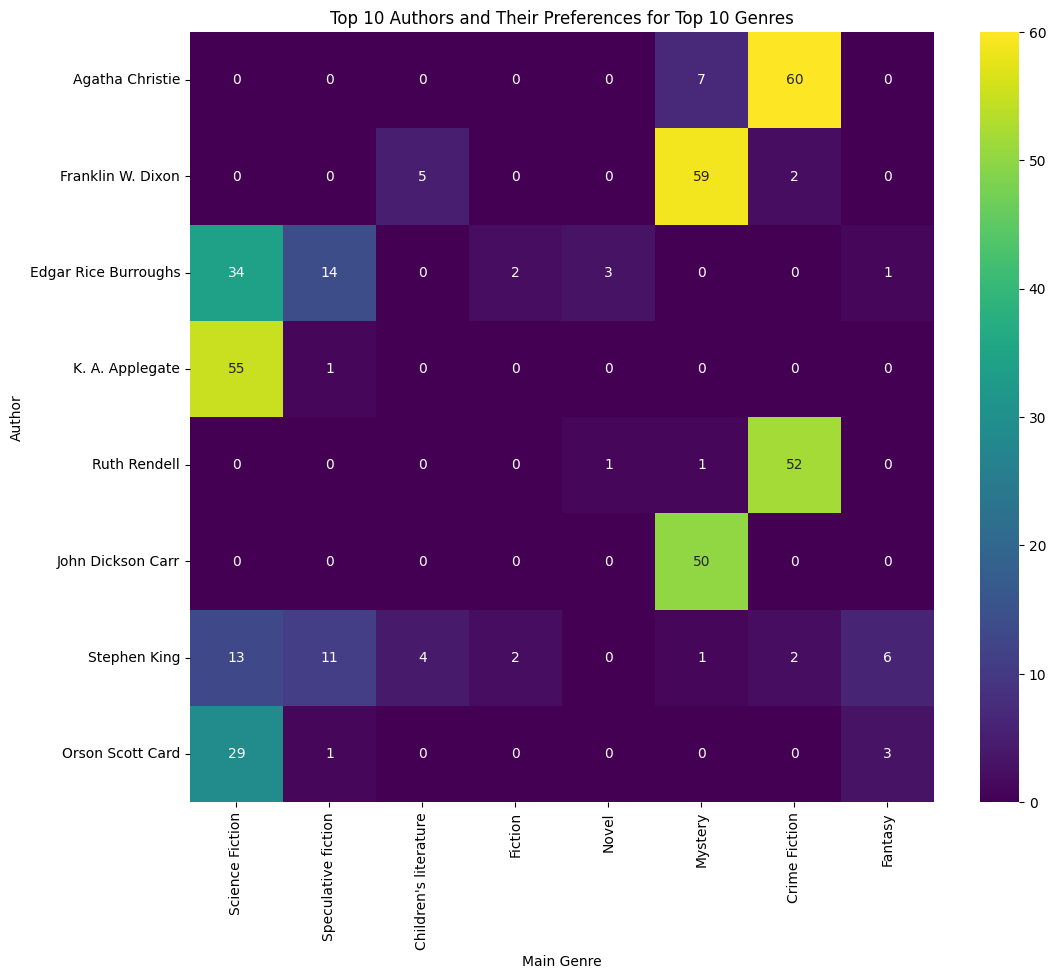

In [15]:
df_3 = df[df['Author'] != 'unknown'].copy()

def extract_main_genre(genre_json):
    try:
        genre_data = json.loads(genre_json)
        return next(iter(genre_data.values())) if genre_data else None
    except json.JSONDecodeError:
        return None

df_3['Info'] = df_3['Info'].astype(str)

df_3['main_genre'] = df_3['Info'].apply(extract_main_genre)

df_3.dropna(subset=['main_genre'], inplace=True)

genre_author_matrix = df_3.groupby(['Author', 'main_genre']).size().unstack(fill_value=0)

top_genres = genre_author_matrix.sum().nlargest(8).index

top_authors = df_3['Author'].value_counts().nlargest(8).index

genre_author_matrix = genre_author_matrix.loc[top_authors, top_genres]

plt.figure(figsize=(12, 10))
sns.heatmap(genre_author_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Top 10 Authors and Their Preferences for Top 10 Genres')
plt.xlabel('Main Genre')
plt.ylabel('Author')
plt.show()

as we see Stephen king has several books on several genres but someone like John Dickson Carr only focuses on one genre

### 5- Identify the most frequently occurring words in the books (excluding common stopwords)

In [18]:
nltk.download('stopwords')
nltk.download('punkt')  # for tokenization
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keyhan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Keyhan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [27]:
def clean_text(text):  # a function to  
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words] 
    return " ".join(filtered_tokens)


In [28]:
df_4 = df.copy()
df_4['cleaned_text'] = df_4['Text'].apply(clean_text)
all_text = " ".join(df_4['cleaned_text'].tolist())


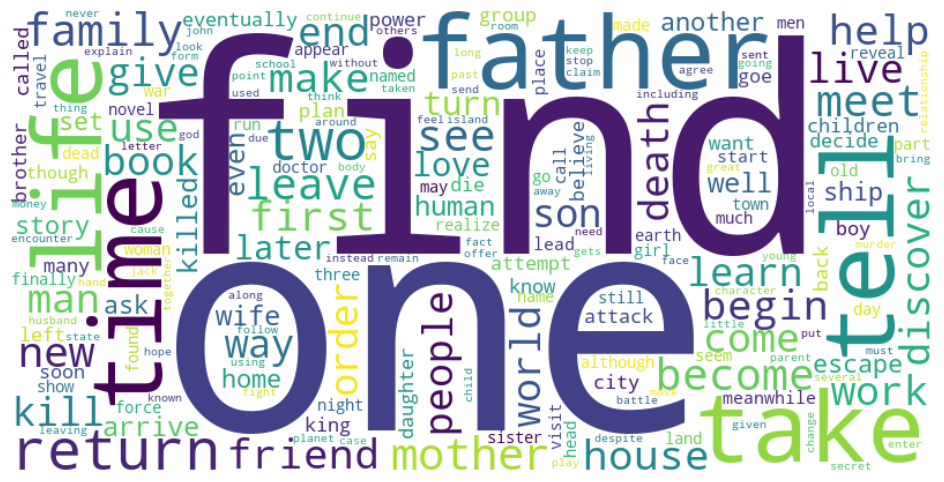

In [39]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

# Summarization

### download the selected model for summarization

In [ ]:
import torch
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    "pszemraj/long-t5-tglobal-base-16384-book-summary",
    device=0 if torch.cuda.is_available() else -1,
)



### use model for all books and save them in a list 

In [ ]:
summaries = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    summary = summarizer(row["Text"])
    summaries.append(summary)
    if (index) % 5 == 0:
        torch.cuda.empty_cache()



### saving the results into a csv file 

In [ ]:
# import csv
# result_file = open("Summaries.csv",'wb')
# with open('output2.csv','w') as result_file:
#     wr = csv.writer(result_file, dialect='excel')
#     wr.writerows(summaries)

### load the results in future uses 

In [133]:

Summaries = pd.read_csv('Summaries.csv' , names=['Summaries'])
Summaries.head(5)


Summaries
0  {'summary_text': 'Old Major calls the animals ...
1  {'summary_text': 'The narrator introduces us t...
2  {'summary_text': "The novel opens with a descr...
3  {'summary_text': 'Hume begins the book by intr...
4  {'summary_text': 'The novel opens with a descr...

In [134]:
summaries = Summaries['Summaries'].to_list()

### Cleaning the results of summaries 

In [135]:
for i in range(len(summaries)):            
    summaries[i] = json.loads(summaries[i]
                              .replace('\\', '')   #We standardized the JSON file through trial and error.
                              .replace('"', '\\"')
                              .replace('{\'summary_text\': \'', '{"summary_text": "')
                              .replace('{\'summary_text\': \\"', '{"summary_text": "')
                              .replace('{\\"summary_text\\": \\"', '{"summary_text": "')
                              .replace('\'}', '"}')
                              .replace('\\\"}', '"}')
                              )['summary_text']



### Add summaries as a coloumn of our main dataset  

In [136]:
df['Summaries'] = summaries


### Displaying Some Randomly Selected Summarized Text with Associated Book Titles

In [149]:

random_rows = df.sample(n=9)

html = '<div style="font-family: Arial; font-size: 14px;">'
for index, row in random_rows.iterrows():
    html += f'<h3 style="color: #0080ff;">{row["Title"]}</h3><p>{row["Summaries"][:2000]}{"..." if len(row["Summaries"]) > 2000 else ""}</p>'
html += '</div>'

display(HTML(html))



# Text-to-Image 

### download the selected model 

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")



### creating photos with summarized text

In [ ]:
photo_names = []


for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    name = str(index)+'_'+str(row['Title'])+'.png'
    prompt = row['Summaries']
    photo = pipe(prompt).images[0]
    try:
        photo.save(f'images/{name}') 
    except:
        photo.save(str(index)+'.png')
    photo_names.append(name)
    if (index) % 5 == 0:
        torch.cuda.empty_cache()




## mistakes correction

### some files didn't save properly 

In [ ]:

arr = os.listdir('images/')

for i, value in tqdm(enumerate(arr), total=len(arr)):
    if value.endswith('.png'):
        continue

    else:
        try:
            os.remove(f"images/{value}")
            name = value + '.png'
            index = int(value.split('_')[0])
            prompt = df.loc[index]['Summaries']
            photo = pipe(prompt).images[0]
            try:
                photo.save(f'images/{name}') 
            except:
                photo.save("images/" + str(index)+'.png')
            # photo_names.append(name)
            if (i) % 5 == 0:
                torch.cuda.empty_cache()
        except:
            continue



### a function designed to detect black images

In [36]:
from PIL import Image

def is_image_all_black(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    pixels = img.getdata()  
    return all(pixel == 0 for pixel in pixels)




The image is not completely black.


### Removing the black images 

In [106]:
arr = os.listdir('images/')

for i, value in tqdm(enumerate(arr), total=len(arr)):
    try:

        if is_image_all_black(f'images/{value}'):
                os.remove(f"images/{value}")

    except:
        continue



100%|██████████| 16559/16559 [03:18<00:00, 83.48it/s]


### Double Summarization to Navigate Policy Constraints

In [109]:
arr = os.listdir('images/')    

index_list = []   # a list to find what indexes are in the images already
for i in arr:
    try:
        index_list.append(int(i.split('_')[0]))
    except:
        index_list.append(int(i.split('.')[0]))


In [ ]:
for i in range(len(df)):
    if not i in index_list: # if the iamge is not created b
        print(f"------------------------------------------------------- {i} ---------------------------------------------------")   # to display what index is getting recreated 
        prompt = df.iloc[i]['Summaries']
        prompt = summarizer(prompt)[0]['summary_text']   
        photo = pipe(prompt).images[0]
        photo.save(f"{i}.png")

        if (i) % 3 == 0:
            torch.cuda.empty_cache()
        



### Displaying Some Random Images with Associated Book Titles

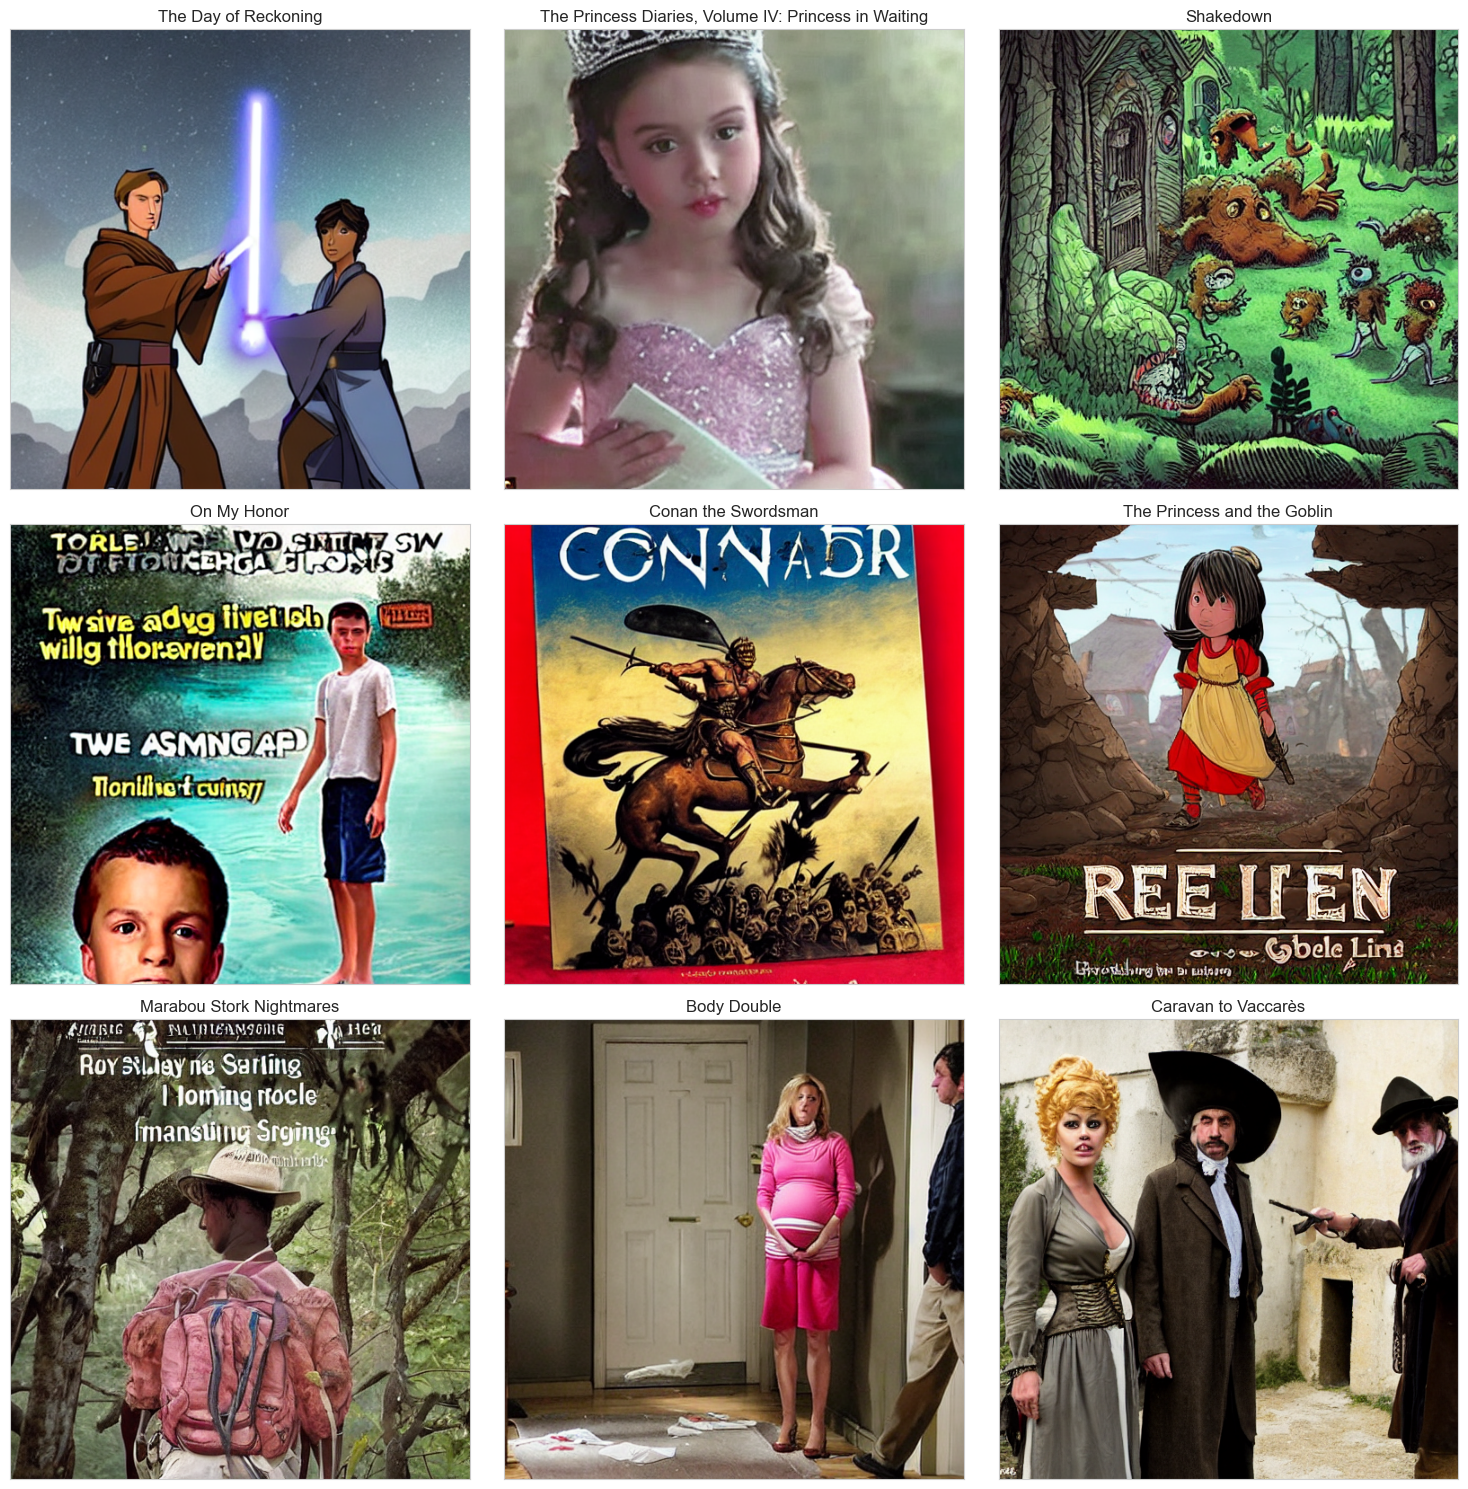

In [40]:
directory = 'images/'

images = os.listdir(directory)

selected_images = random.sample(images, 9)   #pick 9 randomly 

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(directory, img_name)
    try:
        index = int(img_name.split('_')[0])
        img_name = df.iloc[index]['Title']  

    except:
        index = int(img_name.split('.')[0])
        img_name = df.iloc[index]['Title']
        
    image = imread(img_path)
    ax.imshow(image)
    ax.set_title(img_name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
